In [4]:
import torch
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score


from transformers import *
import re
from tqdm.notebook import tqdm

import utils
import pickle

/home/data/ysunbc/anaconda3/envs/yusen/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/data/ysunbc/anaconda3/envs/yusen/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/data/ysunbc/anaconda3/envs/yusen/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/data/ysunbc/anaconda3/envs/y

In [5]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

## Load Pretrained GPT2, dataset and labels

In [6]:
MODEL = 'gpt2-large' 
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(MODEL, cache_dir='./cache')
gpt2 = GPT2LMHeadModel.from_pretrained(MODEL, cache_dir='./cache').to(device)

path = 'Dataset/emotion/'
results = 'results/'

with open(path + 'label2idx.pkl', 'rb') as f:
    label2idx = pickle.load(f)

## Define Function

In [9]:
def get_LM_loss_GPT(model, input_tokens):
    model.eval()
    with torch.no_grad():
        lm_loss = model(input_tokens, labels=input_tokens)[0]
        
    return lm_loss

In [29]:
def test_by_gpt2(model, tokenizer, df, answers, topk, record):
    B_correct_num_3 = 0
    B_correct_num_2 = 0
    B_correct_num_1 = 0
    B_total_num = 0
    PREDICTED_LOSS = []
    TRUE_LABEL =[]
    Predicted_LABELS = []
    incorrect_sourse = []
    incorrect_idx = []
    Question = 'What does the person feel?'
    for i in tqdm(range(len(df))):

        scores = []
        target_answer, Context,= df['label'].iloc[i], df['sentence'].iloc[i]

        for answer in answers:

            Input = 'CONTEXT: ' + str(Context) + '\n' + 'QUESTION: ' + str(Question) + '\n' + 'ANSWER: ' + answer
            FA_tensor = torch.tensor(tokenizer.encode(Input)).to(device)

            loss_0 = get_LM_loss_GPT(model, FA_tensor)

            scores.append(loss_0)


        PREDICTED_LOSS.append(scores)

        label_idx = torch.tensor(answers.index(target_answer))
        TRUE_LABEL.append(label_idx)

        predicted_label = torch.topk(torch.tensor(scores), k=topk[-1], largest=False)[1]
        Predicted_LABELS.append(predicted_label)
        if label_idx in predicted_label:
            B_correct_num_3+=1
        if label_idx in predicted_label[:topk[-2]]:
            B_correct_num_2+=1
        if label_idx == predicted_label[0]:
            B_correct_num_1+=1
        else:
            incorrect_sourse.append(df['source'].iloc[i])
            incorrect_idx.append(i)
        B_total_num+=1

        print(f'\r{i+1}/{len(df)}, top1: {np.around(B_correct_num_1/B_total_num, 3)},top{topk[1]} {np.around(B_correct_num_2/B_total_num, 3)}, top{topk[2]} {np.around(B_correct_num_3/B_total_num, 3)} ', end='')
    
    record['Question'] = Question
    record['TRUE_LABEL'] = [i.numpy() for i in TRUE_LABEL]
    record['PREDICTED_LABEL'] =  [i.numpy() for i in Predicted_LABELS]
    record['f1'] = f1_score(TRUE_LABEL, [i[0] for i in Predicted_LABELS], average='weighted')
    record['top'+str(topk[2])] = np.around(B_correct_num_3/B_total_num, 3)
    record['top'+str(topk[1])] = np.around(B_correct_num_2/B_total_num, 3)
    record['top1'] = np.around(B_correct_num_1/B_total_num, 3)
    record['Answers'] = answers

## Test on noval dataset by pretrained gpt2

In [12]:
record_noval = {}
top3 = [1, 2, 3]
noval_df = pd.read_csv(path+'noval.csv') 
all_answers = list(label2idx.keys())
noval_answers = [ i for i in all_answers if i in noval_df['label'].unique()]

In [13]:
test_by_gpt2(gpt2, gpt2_tokenizer, noval_df, noval_answers, top3, record_noval)

2000/2000, top5: 0.486,top3 0.734, top1 0.888 


In [16]:
record_noval['f1']

0.4584564420443413

In [14]:
file = open(results + "gpt2_noval.pkl", "wb")
pickle.dump(record_noval, file)
file.close()

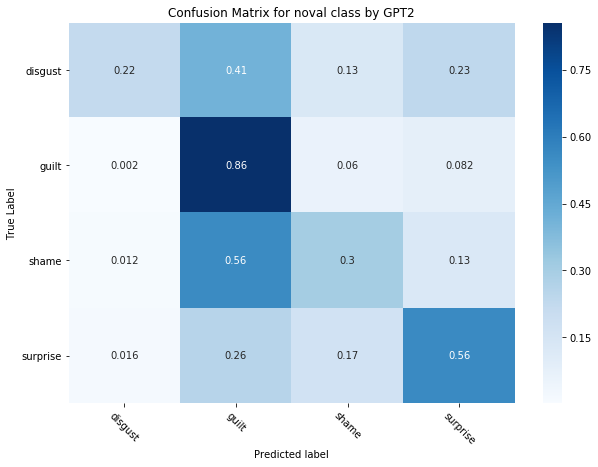

In [15]:
y_true = record_noval['TRUE_LABEL']
y_pred = [i[0] for i in record_noval['PREDICTED_LABEL']]
cm = utils.plot_confusion_matrix(y_true, y_pred, 'Confusion Matrix for noval class by GPT2', 'gpt2_cm_noval', record_noval['Answers'])

## Test on support dataset by pretrained gpt2

In [22]:
record_sup = {}
top3 = [1, 2, 3]
sup_df = pd.read_csv(path+'support.csv') 
all_answers = list(label2idx.keys())
sup_answers = [ i for i in all_answers if i in sup_df['label'].unique()]

In [23]:
test_by_gpt2(gpt2, gpt2_tokenizer, sup_df, sup_answers, top3, record_sup)

2500/2500, top5: 0.418,top3 0.614, top1 0.766 


In [33]:
record_sup['f1']

0.38431942858968116

In [26]:
file = open(results + "gpt2_sup.pkl", "wb")
pickle.dump(record_sup, file)
file.close()

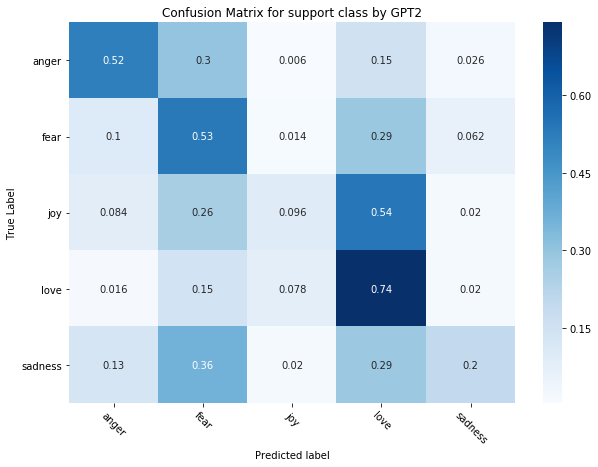

In [27]:
y_true = record_sup['TRUE_LABEL']
y_pred = [i[0] for i in record_sup['PREDICTED_LABEL']]
cm = utils.plot_confusion_matrix(y_true, y_pred, 'Confusion Matrix for support class by GPT2', 'gpt2_cm_support', record_sup['Answers'])

## Test on test dataset by pretrained gpt2

In [28]:
record_test = {}
top5 = [1, 3, 5]
test_df = pd.read_csv(path+'test_full.csv') 
test_answers = list(label2idx.keys())

In [32]:
test_by_gpt2(gpt2, gpt2_tokenizer, test_df, test_answers, top5, record_test)

4500/4500, top1: 0.289,top3 0.557, top5 0.756 


In [34]:
record_test['f1']

0.25202936107188156

In [35]:
file = open(results + "gpt2_test.pkl", "wb")
pickle.dump(record_test, file)
file.close()

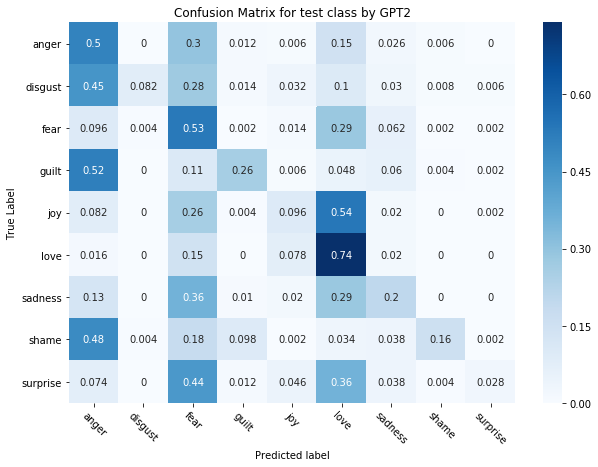

In [36]:
y_true = record_test['TRUE_LABEL']
y_pred = [i[0] for i in record_test['PREDICTED_LABEL']]
cm = utils.plot_confusion_matrix(y_true, y_pred, 'Confusion Matrix for test class by GPT2', 'gpt2_cm_test', record_test['Answers'])

## Load noval results

In [26]:
import pickle
import utils

results = 'results/'

with open(results + 'gpt2_noval.pkl', 'rb') as f:
    record = pickle.load(f)

In [29]:
record['f1'], record['top1'], record['top3'] , record['top5'] 

(0.4584564420443413, 0.486, 0.888, 0.0)

## Load support results

In [ ]:
import pickle
import utils

results = 'results/'

with open(results + 'gpt2_sup.pkl', 'rb') as f:
    record = pickle.load(f)

In [ ]:
record['f1'], record['top1'], record['top3'] , record['top5'] 

## Load test results

In [ ]:
import pickle
import utils

results = 'results/'

with open(results + 'gpt2_test.pkl', 'rb') as f:
    record = pickle.load(f)

In [ ]:
record['f1'], record['top1'], record['top3'] , record['top5'] 